In [1]:
# Bibliotecas necessarias
import cv2
import sys
import numpy as np
from scipy import ndimage as ndimage
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec


In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [3]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [4]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [5]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [6]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [7]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

# Pegue a imagem.

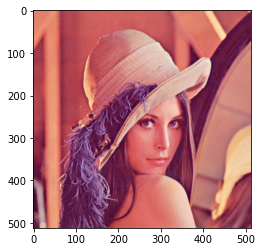

<Figure size 720x720 with 0 Axes>

In [8]:
img = cv2.imread("images/lena_std.tif")[:,:,::-1]
plt.imshow(img, cmap='gray')
plt.figure(figsize = (10,10))
plt.show() 

# Filtrar para o cinza

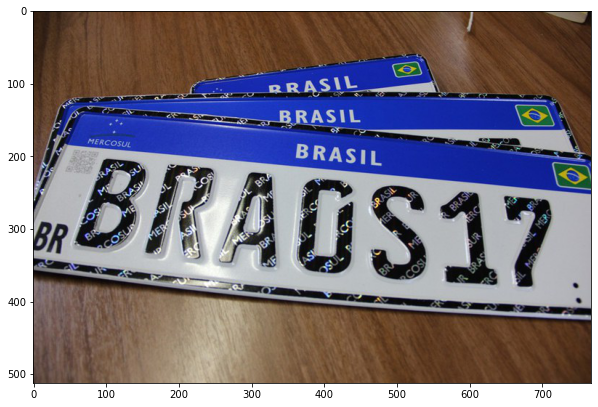

In [9]:
img = cv2.imread("images/placa-gov.jpeg")[:,:,::-1]
gray = rgb2gray(img)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')
plt.show() 

# Filtrar com Gauss

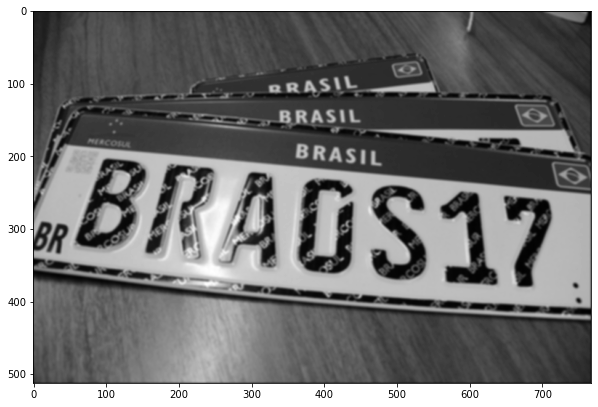

In [20]:
img_filtered = ndimage.filters.convolve(gray, gaussian_kernel(5, sigma=1.4), mode='constant')
plt.figure(figsize = (10,10))
plt.imshow(img_filtered, cmap='gray')
plt.show()

# Encontrar gradiente e direção (Theta) com Sobel

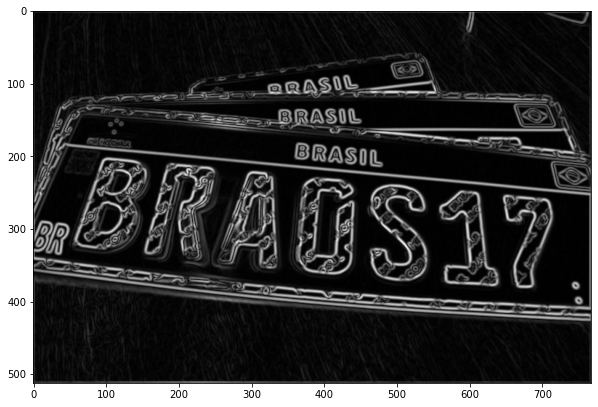

In [13]:
grad, theta = sobel_filters(img_filtered)

sob = np.hypot(grad, theta)

data = np.array(sob).tolist()
plt.figure(figsize = (10,10))
plt.imshow(data, cmap='gray')
plt.show() 

# Afinar as bordas com non_max_supress

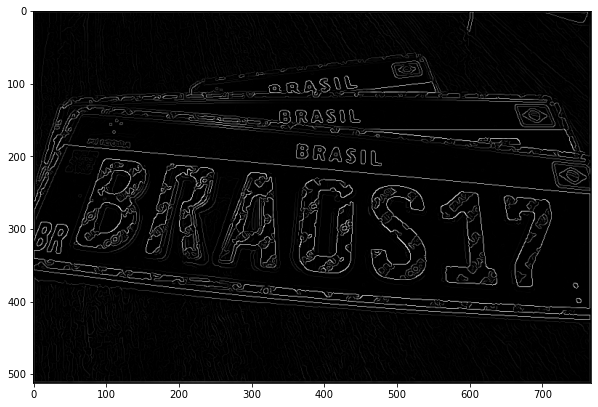

In [18]:
img_nms = non_max_suppression(grad, theta)
plt.figure(figsize = (10,10))
plt.imshow(img_nms, cmap='gray')
plt.show() 

# Separar as bordas fracas e fortes

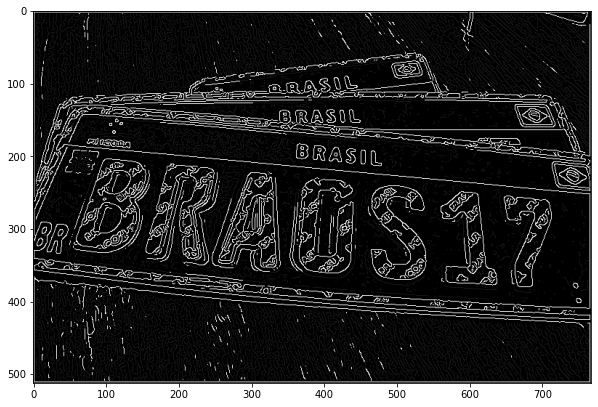

In [19]:
imgn, weak, strong = threshold(img_nms, 0.05, 0.09)
plt.figure(figsize = (10,10))
plt.imshow(imgn, cmap='gray')
plt.show() 

# Por fim, apagar bordas indesejadas com Histeresys

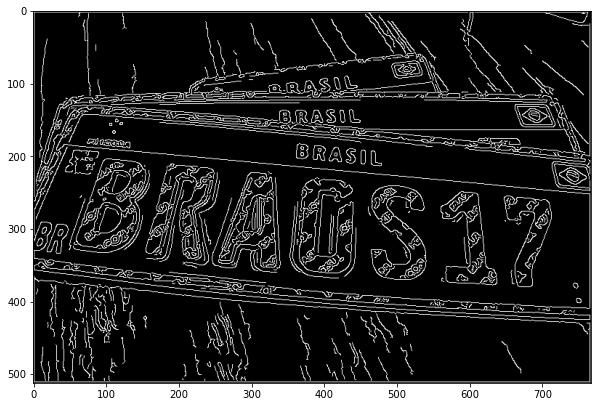

In [16]:
hist = hysteresis(imgn, weak, strong=strong)
plt.figure(figsize = (10,10))
plt.imshow(hist, cmap='gray')
plt.show() 

In [17]:
def Canny_detector(img):
    img_filtered = convolve(img, gaussian_kernel(5, sigma=1.4))
    grad, theta = sobel_filters(img_filtered)
    img_nms = non_max_suppression(grad, theta)
    img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.09, highThresholdRatio=0.17)
    img_final = hysteresis(img_thresh, 25, strong)
   
    return img_final